# Traveling Salesperson Problem
ref: https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm

In [2]:
from TSP.model import Tsp

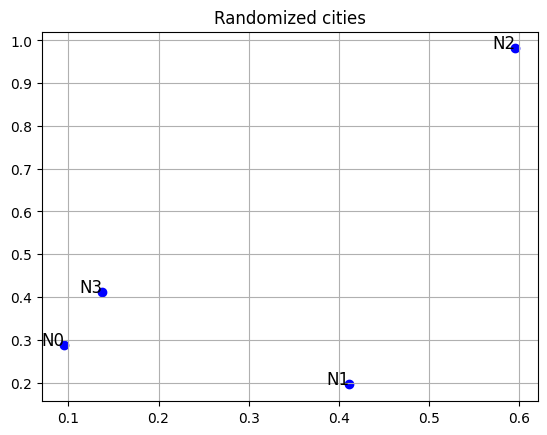

array([[0, 3, 8, 1],
       [3, 0, 8, 3],
       [8, 8, 0, 7],
       [1, 3, 7, 0]])

In [3]:
# Create a random TSP problem
tsp = Tsp(4, initial_plot=True)
tsp.distance_matrix

## Brute force solve

Best order from brute force = (0, 1, 2, 3) with total distance = 19


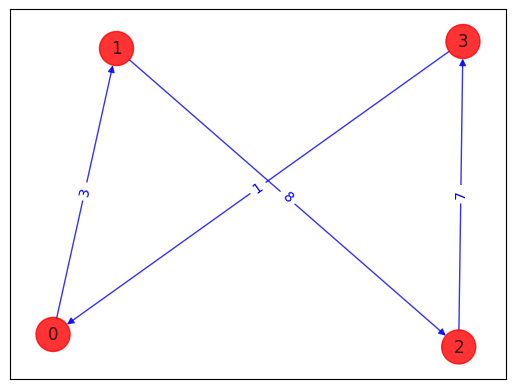

In [4]:
best_order, best_distance = tsp.brute_force()

tsp.draw_tour(best_order)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)

## Formulating QUBO

For $N$ cities, use $N^2$ binary variables x(i,p), where i represents the index of a city and p represents the order of the city in the route. In other words, if city i is visited at step p of the route, then x(i,p) = 1.

Constraints\
This euations ensure that each city is visited only once, and each step of the route is in one city.
$
\begin{gather}
\sum_{p=0}^{N-1} ( 1 - \sum_{i=0}^{N-1} x(i, p) )^2 = 0 \\
\sum_{i=0}^{N-1} ( 1 - \sum_{p=0}^{N-1} x(i, p) )^2 = 0 \\ 
\sum_{i=0}^{N-1} x_{i, p} = 1,\ for\ all\ p \\
\sum_{p=0}^{N-1} x_{i, p} = 1,\ for\ all\ i \\
\end{gather}
$

Objective\
Find the shortest Hamiltonian cycle in a graph
$
\begin{gather}
C(x) = \sum_{i, j} w_{i, j} \sum_{p=0}^{N-1} x_{i, p}x_{j, p + 1}  \\
\end{gather}
$

In [5]:
qubo = tsp.qubo(penalty=10, format="ising")
qubitOp = qubo["model"]
offset = qubo["offset"] 

print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 220.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII', 'IIIIIIIIZIIIIZII', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIZIIIIIIIIZII', 'IIZIIIIIIIIIIZII', 'IZIIIIIIIII

## Running on quantum computer
qiskit_algorithms QAOA not supported

### Initialize QAOA ansatz

In [12]:
from qiskit.circuit.library import QAOAAnsatz
import numpy as np

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


reps = 1
circuit = QAOAAnsatz(qubitOp, reps=reps)
# circuit.measure_all()

pm = generate_preset_pass_manager(optimization_level=1)
candidate_circuit = pm.run(circuit)

initial_gamma = np.pi
initial_beta = np.pi/2
init_params = []
for _ in range(reps):
    init_params.extend([initial_gamma, initial_beta])

# circuit.draw("mpl")
# circuit.decompose().draw('mpl')

In [6]:
objective_func_vals = [] # Global variable
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

### Running QAOA
quantum estimate -> optimize with L-BFGS-B 
rinse and repeat

In [7]:
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator()
result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, qubitOp, estimator),
    method="COBYLA",
    tol=300,
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 7.641997422795391
       x: [ 4.142e+00  6.728e-01  2.702e+00  2.571e+00]
    nfev: 6
   maxcv: 0.0


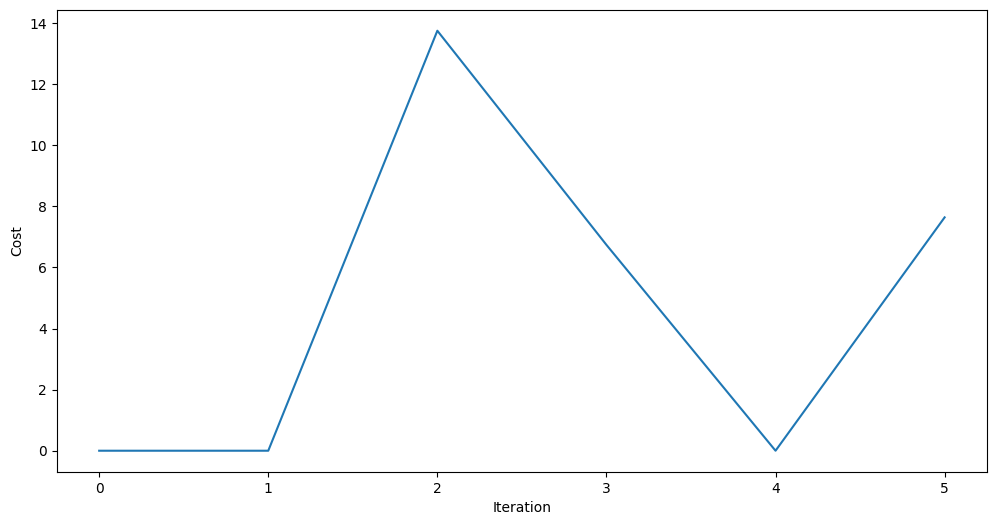

70.64199742279538


In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()
print(objective_func_vals[-1] + offset)

### Update the quantum circuit parameters with optimized param

In [9]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.measure_all()
# optimized_circuit.draw('mpl', fold=False, idle_wires=False)

### Using the optimized ciruit to sample result

In [10]:
from qiskit.primitives import StatevectorSampler as Sampler
sampler = Sampler() 

pub = (optimized_circuit, )

job = sampler.run([pub], shots=1000)
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{378: 0.003, 192: 0.012, 269: 0.003, 433: 0.014, 418: 0.003, 71: 0.002, 179: 0.003, 399: 0.005, 254: 0.001, 468: 0.004, 493: 0.017, 500: 0.002, 265: 0.002, 492: 0.004, 426: 0.004, 464: 0.004, 306: 0.003, 109: 0.007, 473: 0.001, 383: 0.009, 231: 0.003, 475: 0.012, 63: 0.037, 104: 0.004, 505: 0.01, 259: 0.002, 506: 0.011, 246: 0.002, 33: 0.016, 131: 0.006, 186: 0.005, 444: 0.002, 320: 0.007, 487: 0.005, 248: 0.006, 64: 0.006, 28: 0.002, 34: 0.016, 133: 0.003, 256: 0.004, 10: 0.011, 220: 0.014, 316: 0.004, 128: 0.006, 398: 0.007, 255: 0.01, 494: 0.002, 359: 0.004, 469: 0.007, 341: 0.009, 331: 0.005, 107: 0.006, 173: 0.001, 419: 0.002, 461: 0.001, 351: 0.001, 202: 0.003, 154: 0.002, 91: 0.005, 311: 0.002, 474: 0.001, 447: 0.013, 155: 0.004, 356: 0.003, 430: 0.003, 497: 0.001, 376: 0.002, 108: 0.005, 425: 0.003, 485: 0.003, 334: 0.003, 122: 0.002, 199: 0.009, 180: 0.004, 79: 0.005, 50: 0.002, 391: 0.007, 448: 0.011, 471: 0.006, 428: 0.004, 477: 0.001, 242: 0.003, 20: 0.013, 407: 0.004, 353:

In [11]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, 9)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)


result = tsp.interpret(most_likely_bitstring)

Result bitstring: [1, 1, 1, 1, 1, 1, 0, 0, 0]


In [12]:
result


array([1., 1., 1.])

In [ ]:
from qiskit_algorithms import QAOA

qaoa = QAOA(sampler=Sampler(), optimizer=minimize, reps=2)